In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date,datetime,timedelta
from math import floor
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Import ticker list for S&P500

import yahoo_fin.stock_info as si

tickers_list = si.tickers_sp500()
tickers_list.remove('OGN')

In [3]:
# Function - RSI

def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [4]:
# Historical data for 500days

def stock_data_all(ticker):
    # start_date1 = date.today()
    end_date1 = date.today()-timedelta(days=300)
    # start_date = start_date1.strftime("%Y-%m-%d")
    end_date = end_date1.strftime("%Y-%m-%d")

    # Request data:
    data = yf.download(ticker,
                        end_date)
    
    return data

In [5]:
stock_final = pd.DataFrame()

for ticker in tqdm(tickers_list):   
    stock = []
    stock = stock_data_all(ticker)
 
    if len(stock) == 0:
        None
    else:
        stock['Ticker']=ticker
        stock_final = stock_final.append(stock,sort=False)

  0%|          | 0/504 [00:00<?, ?it/s]

************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%******************

In [6]:
stock_final2 = stock_final[['Ticker','Open','High','Low','Adj Close','Volume']]
stock_final2 = stock_final2.rename(columns={'Adj Close': 'Close'}, inplace=False)
stock_final2

,Ticker,Open,High,Low,Close,Volume
Date,,,,,,
2020-09-08,A,96.110001,96.470001,94.760002,94.544952,1225600
2020-09-09,A,96.099998,98.470001,95.860001,97.317505,954400
2020-09-10,A,98.879997,100.099998,98.239998,97.953506,1933200
2020-09-11,A,98.709999,99.620003,98.019997,97.983307,1368600
2020-09-14,A,99.730003,100.230003,98.970001,98.798180,1207700
...,...,...,...,...,...,...
2021-06-28,ZTS,187.339996,187.929993,185.639999,187.080002,1386100
2021-06-29,ZTS,187.089996,188.190002,186.089996,187.990005,853900
2021-06-30,ZTS,188.110001,188.529999,185.580002,186.360001,1203600


In [7]:
sctr = stock_final2[['Ticker','Close']]
sctr

,Ticker,Close
Date,,
2020-09-08,A,94.544952
2020-09-09,A,97.317505
2020-09-10,A,97.953506
2020-09-11,A,97.983307
2020-09-14,A,98.798180
...,...,...
2021-06-28,ZTS,187.080002
2021-06-29,ZTS,187.990005
2021-06-30,ZTS,186.360001


In [8]:
# SCTR
sctr['exp200'] = sctr['Close'].ewm(span=200, adjust=False).mean()
sctr['sctrlt_200ema'] = (sctr['Close']/sctr['exp200'] - 1)*100*0.3

sctr['125_day_roc'] = sctr['Close'].pct_change(periods=125) *100
sctr['sctrlt_roc125'] = sctr['125_day_roc']*0.3

sctr['exp50'] = sctr['Close'].ewm(span=50, adjust=False).mean()
sctr['sctrmt_ema50'] = (sctr['Close']/sctr['exp50'] -1)*100*0.15

sctr['20_day_roc'] = sctr['Close'].pct_change(periods=20) *100
sctr['sctrmt_roc20'] = sctr['20_day_roc']*0.15
sctr['PPO'] = (sctr['Close'].ewm(span=12, adjust=False).mean() - sctr['Close'].ewm(span=26, adjust=False).mean())/(sctr['Close'].ewm(span=26, adjust=False).mean()) *100

sctr['PPO_signal'] = sctr['PPO'].ewm(span=9, adjust=False).mean()
sctr['PPO_histogram'] = sctr['PPO'] - sctr['PPO_signal']
sctr['adj3'] = sctr['PPO_histogram'].shift(2)
sctr['PPO_3_day_slope'] = (sctr['PPO_histogram'] - sctr['adj3'])/3
sctr['sctrst_ppo'] = ((sctr['PPO_3_day_slope'] + 1)*50) * 0.05
sctr['rsi'] = rsiFunc(sctr['Close'], n=14)
sctr['sctrst_rsi'] = sctr['rsi'] *0.05

sctr['SCTR'] = sctr['sctrlt_200ema'] + sctr['sctrlt_roc125'] + sctr['sctrmt_ema50'] + sctr['sctrmt_roc20'] + sctr['sctrst_ppo'] + sctr['sctrst_rsi']
sctr = sctr.filter(['Date','Ticker','SCTR'])
sctr.head(10)

<ipython-input-8-f30b3868d5e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sctr['exp200'] = sctr['Close'].ewm(span=200, adjust=False).mean()
<ipython-input-8-f30b3868d5e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sctr['sctrlt_200ema'] = (sctr['Close']/sctr['exp200'] - 1)*100*0.3
<ipython-input-8-f30b3868d5e7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,Ticker,SCTR
Date,,
2020-09-08,A,NaN
2020-09-09,A,NaN
2020-09-10,A,NaN
2020-09-11,A,NaN
2020-09-14,A,NaN
2020-09-15,A,NaN
2020-09-16,A,NaN
2020-09-17,A,NaN
2020-09-18,A,NaN


In [9]:
# Stochastics
stoch = stock_final2[['Ticker','High','Low','Close']]
stoch1 = pd.DataFrame()
stoch1['Ticker'] = stoch['Ticker']
stoch1['5-high'] = stoch['High'].rolling(5).max()
stoch1['5-low'] = stoch['Low'].rolling(5).min()
stoch1['%K'] = (stoch['Close'] - stoch1['5-low'])*100/(stoch1['5-high'] - stoch1['5-low'])
stoch1['%D'] = stoch1['%K'].rolling(3).mean()
stoch = stoch1.filter(['Date','Ticker','%D'])

stoch.head(10)

,Ticker,%D
Date,,
2020-09-08,A,NaN
2020-09-09,A,NaN
2020-09-10,A,NaN
2020-09-11,A,NaN
2020-09-14,A,NaN
2020-09-15,A,NaN
2020-09-16,A,61.893458
2020-09-17,A,46.374335
2020-09-18,A,27.752549


In [10]:
# 200SMA
sma_200 = stock_final2[['Ticker','Close']]
sma_200_1 = pd.DataFrame()
sma_200_1['Ticker'] = sma_200['Ticker']
sma_200_1['200SMA'] = sma_200['Close'].rolling(200).mean()
sma_200_1['200SMA_diff'] = ((sma_200['Close']/sma_200_1['200SMA'])-1)*100
# sma_200_1 = sma_200_1.round({'200SMA_diff': 2})
sma_200 = sma_200_1 

In [11]:
# 50SMA
sma_50 = stock_final2[['Ticker','Close']]
sma_50_1 = pd.DataFrame()
sma_50_1['Ticker'] = sma_50['Ticker']
sma_50_1['50SMA'] = sma_50['Close'].rolling(50).mean()
sma_50_1['50SMA_diff'] = ((sma_50['Close']/sma_50_1['50SMA'])-1)*100

sma_50 = sma_50_1 

In [12]:
# Lastest stock data
stock_final3 = stock_final2.loc['2021-07-01',:]
stock_final3 = stock_final3.reset_index()
stock_final3

,Date,Ticker,Open,High,Low,Close,Volume
0,2021-07-01,A,147.770004,148.369995,147.009995,147.595993,1426500
1,2021-07-01,AAL,21.469999,21.790001,21.330000,21.510000,22082700
2,2021-07-01,AAP,205.809998,209.179993,204.830002,208.940002,611300
3,2021-07-01,AAPL,136.600006,137.330002,135.759995,137.270004,52485800
4,2021-07-01,ABBV,112.949997,114.550003,112.889999,114.260002,5306900
...,...,...,...,...,...,...,...
499,2021-07-01,YUM,115.489998,116.440002,115.360001,116.010002,1847500
500,2021-07-01,ZBH,161.500000,163.169998,160.710007,163.139999,1136200
501,2021-07-01,ZBRA,530.000000,533.229980,521.020020,532.020020,227500
502,2021-07-01,ZION,53.689999,54.020000,52.919998,53.820000,1021100


In [13]:
# Lastest stoch data
stoch_final = stoch.loc['2021-07-01',:]
stoch_final

,Ticker,%D
Date,,
2021-07-01,A,65.863305
2021-07-01,AAL,19.458205
2021-07-01,AAP,80.760146
2021-07-01,AAPL,94.275364
2021-07-01,ABBV,42.563543
...,...,...
2021-07-01,YUM,22.778266
2021-07-01,ZBH,18.040759
2021-07-01,ZBRA,84.471533


In [14]:
# Lastest 200SMA data
sma_200_final = sma_200.loc['2021-07-01',:]
sma_200_final

,Ticker,200SMA,200SMA_diff
Date,,,
2021-07-01,A,121.876796,21.102620
2021-07-01,AAL,18.242450,17.911795
2021-07-01,AAP,170.631280,22.451172
2021-07-01,AAPL,124.962584,9.848884
2021-07-01,ABBV,102.822190,11.123875
...,...,...,...
2021-07-01,YUM,106.962978,8.458089
2021-07-01,ZBH,155.640492,4.818481
2021-07-01,ZBRA,417.359200,27.472934


In [15]:
# Lastest 50SMA data
sma_50_final = sma_50.loc['2021-07-01',:]
sma_50_final

,Ticker,50SMA,50SMA_diff
Date,,,
2021-07-01,A,137.734760,7.159582
2021-07-01,AAL,22.571400,-4.702410
2021-07-01,AAP,197.913661,5.571288
2021-07-01,AAPL,129.269353,6.189132
2021-07-01,ABBV,114.101200,0.139176
...,...,...,...
2021-07-01,YUM,118.241469,-1.887211
2021-07-01,ZBH,166.171865,-1.824536
2021-07-01,ZBRA,498.506202,6.722849


In [16]:
# Lastest sctr data
sctr_final = sctr.loc['2021-07-01',:]
sctr_final1= pd.DataFrame()
sctr_final1['Ticker'] = sctr_final['Ticker']
sctr_final1['SCTR'] = sctr_final['SCTR']
sctr_final1['Decile_rank'] = pd.qcut(sctr_final['SCTR'],  10000,
                            labels = False) /100

sctr_final = sctr_final1
sctr_final

,Ticker,SCTR,Decile_rank
Date,,,
2021-07-01,A,21.262916,83.89
2021-07-01,AAL,2.047167,15.70
2021-07-01,AAP,27.323108,95.42
2021-07-01,AAPL,10.994490,47.31
2021-07-01,ABBV,9.420841,40.75
...,...,...,...
2021-07-01,YUM,8.317062,37.77
2021-07-01,ZBH,8.909725,39.96
2021-07-01,ZBRA,27.318488,95.22


In [17]:
# Combine table
combined_df = stock_final3.merge(sctr_final, on='Ticker', how='outer')
combined_df = combined_df.merge(stoch_final, on='Ticker', how='outer')
combined_df = combined_df.merge(sma_50_final, on='Ticker', how='outer')
combined_df = combined_df.merge(sma_200_final, on='Ticker', how='outer')
combined_df

,Date,Ticker,Open,High,Low,Close,Volume,SCTR,Decile_rank,%D,50SMA,50SMA_diff,200SMA,200SMA_diff
0,2021-07-01,A,147.770004,148.369995,147.009995,147.595993,1426500,21.262916,83.89,65.863305,137.734760,7.159582,121.876796,21.102620
1,2021-07-01,AAL,21.469999,21.790001,21.330000,21.510000,22082700,2.047167,15.70,19.458205,22.571400,-4.702410,18.242450,17.911795
2,2021-07-01,AAP,205.809998,209.179993,204.830002,208.940002,611300,27.323108,95.42,80.760146,197.913661,5.571288,170.631280,22.451172
3,2021-07-01,AAPL,136.600006,137.330002,135.759995,137.270004,52485800,10.994490,47.31,94.275364,129.269353,6.189132,124.962584,9.848884
4,2021-07-01,ABBV,112.949997,114.550003,112.889999,114.260002,5306900,9.420841,40.75,42.563543,114.101200,0.139176,102.822190,11.123875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2021-07-01,YUM,115.489998,116.440002,115.360001,116.010002,1847500,8.317062,37.77,22.778266,118.241469,-1.887211,106.962978,8.458089
500,2021-07-01,ZBH,161.500000,163.169998,160.710007,163.139999,1136200,8.909725,39.96,18.040759,166.171865,-1.824536,155.640492,4.818481
501,2021-07-01,ZBRA,530.000000,533.229980,521.020020,532.020020,227500,27.318488,95.22,84.471533,498.506202,6.722849,417.359200,27.472934
502,2021-07-01,ZION,53.689999,54.020000,52.919998,53.820000,1021100,-2.445152,7.55,22.699624,56.046678,-3.972900,46.673076,15.312734


In [18]:
# Filter potentials

# Stoch Filter
combined_df_filtered = combined_df.loc[combined_df['%D'] <=20]
# 200 SMA filter
combined_df_filtered = combined_df_filtered.loc[combined_df_filtered['200SMA_diff'] > 0]
# SCTR filter
combined_df_filtered = combined_df_filtered.loc[combined_df_filtered['Decile_rank'] > 90]
# Vol filter
combined_df_filtered = combined_df_filtered.loc[combined_df_filtered['Volume'] > 500000]
# Rank ticker based on SCTR
combined_df_filtered = combined_df_filtered.sort_values(by=['SCTR'], ascending=False)
combined_df_filtered['Volume'] = combined_df_filtered.apply(lambda combined_df_filtered: "{:,}".format(combined_df_filtered['Volume']), axis=1)
combined_df_filtered

,Date,Ticker,Open,High,Low,Close,Volume,SCTR,Decile_rank,%D,50SMA,50SMA_diff,200SMA,200SMA_diff
105,2021-07-01,COF,155.529999,158.059998,155.130005,157.149994,"3,354,200",32.781971,98.01,19.642237,155.743391,0.903154,114.991339,36.662461
324,2021-07-01,NDAQ,177.889999,177.889999,175.800003,176.029999,"1,123,500",25.265976,92.44,14.809127,167.487139,5.100607,142.932693,23.155868
496,2021-07-01,XOM,64.330002,64.419998,62.770000,63.259998,"22,530,300",24.369386,91.05,19.782157,60.483953,4.589722,48.047434,31.661553


In [19]:
shortlist = combined_df_filtered['Ticker'].to_numpy()

In [20]:
import os

shortlist_date = date.today()
shortlist_date = shortlist_date.strftime("%Y-%m-%d")

if not os.path.exists('asset/' + shortlist_date):
    os.makedirs('asset/' + shortlist_date)

In [21]:
from finvizfinance.quote import finvizfinance

for i in shortlist:
    stock = finvizfinance(i)
    stock.TickerCharts(out_dir='asset/' + shortlist_date)

In [22]:
# from IPython.display import Image

# ticker_lookup = input("Enter Ticker:")
# ticker_lookup = ticker_lookup.upper()

# Image(filename='asset/' + shortlist_date + '/' + ticker_lookup + '.jpg')

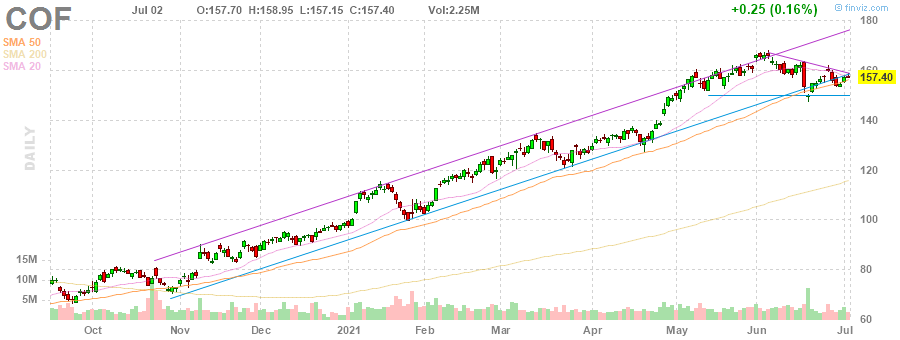

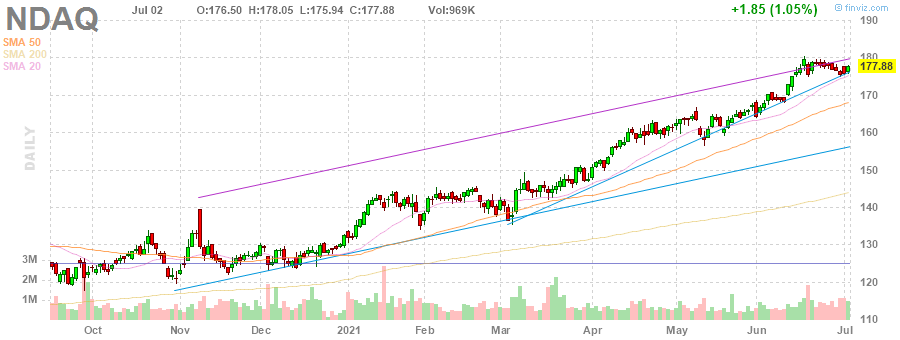

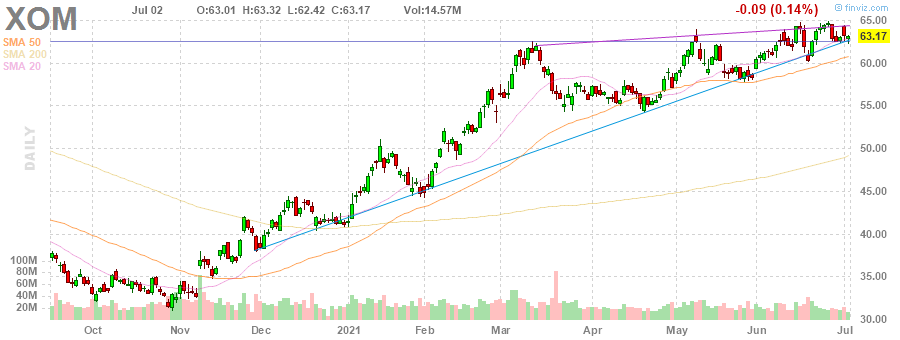

In [23]:
from IPython.display import Image

for i in shortlist:
    img = Image(filename='asset/' + shortlist_date + '/' + i + '.jpg')
    display(img)